In [2]:

import os
import sys

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

sys.path.append('..')
from ann.dense_nets import simpleNet, simpleNet_RK
from data import SwitchData, SwitchData_rk
from tools import (cost, derive_regimes, removeRedundantSwitches,
                   removeWrongOrder, sigmoid, smooth_dap, smooth_regime,
                   sol_ivp_wrapper, stochasticSimulation, setupAxis)


from price_loader import*
from color_loader import *

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2

import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


/Users/madsobdrup/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# MSE loss trajectories

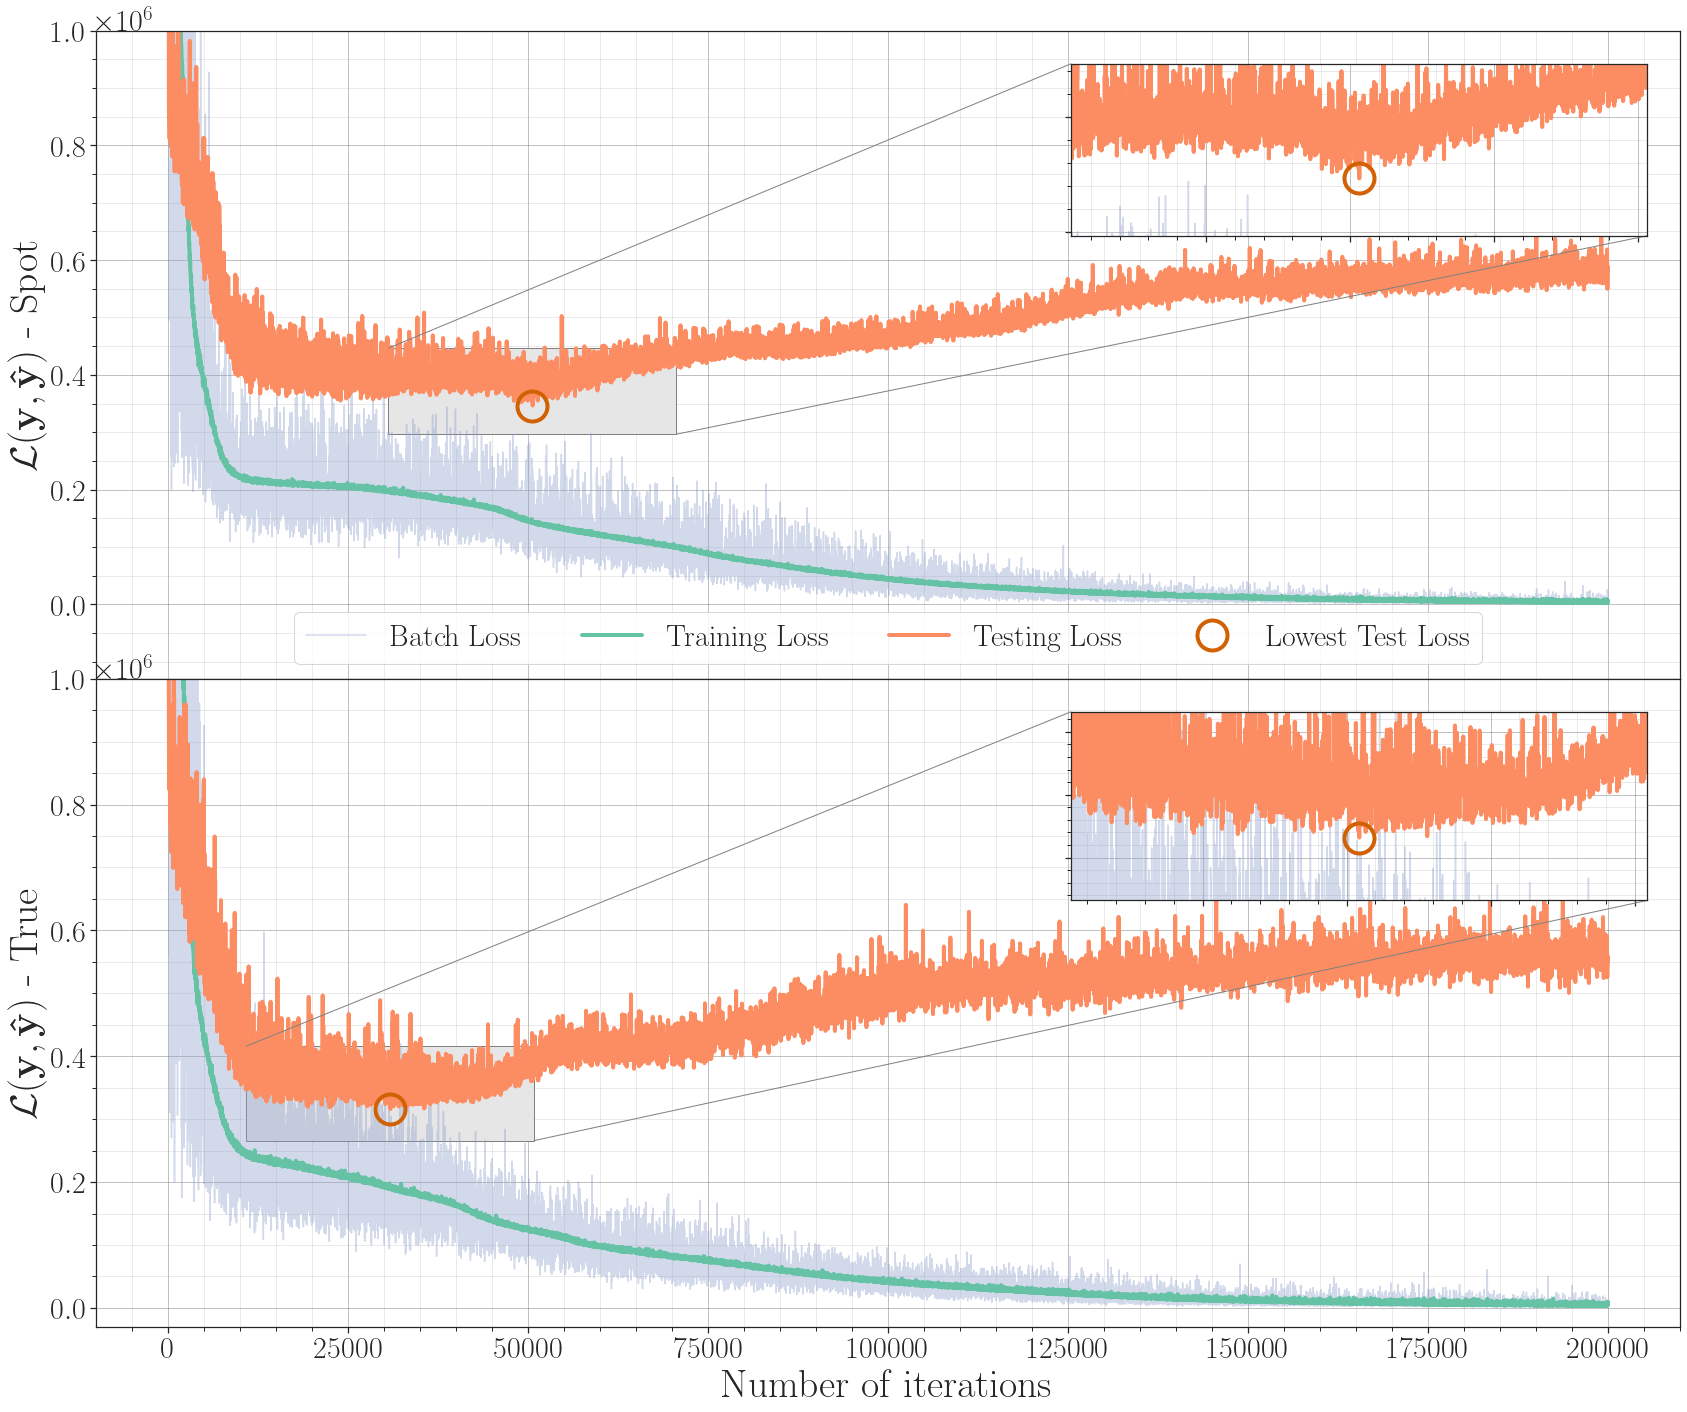

In [3]:
fig = plt.figure(figsize=(25,20))

ax = fig.add_subplot(211);

losses = np.load('../ann/train_info/rk_loss_epoch_switchtype_dap.npy')
losses_train = losses[0,:]
losses_test = losses[1,:]
loss_iteration = np.load('../ann/train_info/rk_loss_iteration_switchtype_dap.npy')
opt_epoch = np.load('../ann/train_info/rk_opt_epoch_switchtype_dap.npy')


model = simpleNet_RK(n_s_all=12)
model.load_state_dict(torch.load('../ann/trained_networks/best_model_rk_switchtype_dap'))
model.eval()


# Plot content
#loss_to_plot_train = losses_train[10:]
#loss_to_plot_test = losses_test[10:]
iterations_epoch = np.arange(20,20*(len(losses_train)+1),20)
iterations = np.arange(len(loss_iteration))
ax.plot(iterations[::10],loss_iteration[::10],color=sns.color_palette("Set2")[2],alpha = 0.4, label=r'$\textnormal{Batch Loss}$')
ax.plot(iterations_epoch, np.array(losses_train), label=r'$\textnormal{Training Loss}$',color=sns.color_palette("Set2")[0],linewidth=4)
ax.plot(iterations_epoch, np.array(losses_test), label=r'$\textnormal{Testing Loss}$',color=sns.color_palette("Set2")[1],linewidth=4)
opt_iter = opt_epoch * 20
ax.plot([opt_iter], [losses_test[opt_epoch]], linestyle='None', marker='o', markersize=30, fillstyle='none', markeredgewidth=4.0,color=colors1[3],label=r'$\textnormal{Lowest Test Loss}$')

setupAxis(ax,ncol_legend=5)
ax.legend(prop={'size': 30},ncol=5,loc = 'lower center')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel(r'$\textnormal{Number of iterations}$')
ax.set_ylabel(r'$\mathcal{L}(\mathbf{y},\mathbf{\hat y)} \textnormal{ - Spot}$')

#ax.set_yticks(np.array([0,1,2,3,4,5]) * 10**6)

#ylim = ax.get_ylim()
ax.set_ylim(ymin = -1.3*10**5, ymax=1 * 10**6)
ax.yaxis.get_offset_text().set_fontsize(30)
#point.plot(x='x', y='y', ax=ax, style='bx', label='point')




#ax.scatter(opt_iter, )

axins = zoomed_inset_axes(ax, 2, loc='upper right', borderpad=3) # zoom-factor: 2.5, location: upper-left
axins.plot(iterations[::10],loss_iteration[::10],color=sns.color_palette("Set2")[2],alpha = 0.4)
axins.plot(iterations_epoch, np.array(losses_train), label=r'$\textnormal{Training Loss}$',color=sns.color_palette("Set2")[0],linewidth=4)
axins.plot(iterations_epoch, np.array(losses_test), label=r'$\textnormal{Testing Loss}$',color=sns.color_palette("Set2")[1],linewidth=4)
axins.plot([opt_iter], [losses_test[opt_epoch]], marker='o', markersize=30, color=colors1[3], fillstyle='none',markeredgewidth=4.0)

setupAxis(axins,nolegend=True)

x1, x2, y1, y2 = opt_iter - 20000, opt_iter + 20000, losses_test[opt_epoch] - 5*10**4, losses_test[opt_epoch] + 10*10**4 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)
axins.set_xlabel(r'')
axins.set_ylabel(r'')

mark_inset(ax, axins, loc1=4, loc2=2, fc="0.9", ec="0.5")




## THEN THE RK MODEL
losses = np.load('../ann/train_info/rk_loss_epoch_switchtype_rk.npy')
losses_train = losses[0,:]
losses_test = losses[1,:]
loss_iteration = np.load('../ann/train_info/rk_loss_iteration_switchtype_rk.npy')
opt_epoch = np.load('../ann/train_info/rk_opt_epoch_switchtype_rk.npy')


model = simpleNet_RK(n_s_all=12)
model.load_state_dict(torch.load('../ann/trained_networks/best_model_rk_switchtype_rk'))
model.eval()


ax = fig.add_subplot(212);

# Plot content
iterations_epoch = np.arange(20,20*(len(losses_train)+1),20)
iterations = np.arange(len(loss_iteration))
ax.plot(iterations[::10],loss_iteration[::10],color=sns.color_palette("Set2")[2],alpha = 0.4)
ax.plot(iterations_epoch, np.array(losses_train), label=r'$\textnormal{Training Loss}$',color=sns.color_palette("Set2")[0],linewidth=4)
ax.plot(iterations_epoch, np.array(losses_test), label=r'$\textnormal{Testing Loss}$',color=sns.color_palette("Set2")[1],linewidth=4)
opt_iter = opt_epoch * 20
ax.plot([opt_iter], [losses_test[opt_epoch]], linestyle='None', marker='o', markersize=30, fillstyle='none', markeredgewidth=4.0,color=colors1[3],label=r'$\textnormal{Lowest Test Loss}$')

setupAxis(ax,ncol_legend=2,nolegend=True)
#ax.legend(prop={'size': 30},ncol=3,loc = 'upper right')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel(r'$\textnormal{Number of iterations}$')
ax.set_ylabel(r'$\mathcal{L}(\mathbf{y},\mathbf{\hat y)} \textnormal{ - True}$')
#ax.set_yticks(np.array([0,1,2,3,4,5]) * 10**5)

ax.set_ylim(ymin = -0.3*10**5, ymax=1 * 10**6)
ax.yaxis.get_offset_text().set_fontsize(30)

# Zoom effect
axins = zoomed_inset_axes(ax, 2, loc='upper right', borderpad=3) # zoom-factor: 2.5, location: upper-left
axins.plot(iterations[::10],loss_iteration[::10],color=sns.color_palette("Set2")[2],alpha = 0.4)
axins.plot(iterations_epoch, np.array(losses_train), label=r'$\textnormal{Training Loss}$',color=sns.color_palette("Set2")[0],linewidth=4)
axins.plot(iterations_epoch, np.array(losses_test), label=r'$\textnormal{Testing Loss}$',color=sns.color_palette("Set2")[1],linewidth=4)
axins.plot([opt_iter], [losses_test[opt_epoch]], marker='o', markersize=30, color=colors1[3], fillstyle='none',markeredgewidth=4.0)

setupAxis(axins,nolegend=True)

x1, x2, y1, y2 = opt_iter - 20000, opt_iter + 20000, losses_test[opt_epoch] - 5*10**4, losses_test[opt_epoch] + 10*10**4 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)
axins.set_xlabel(r'')
axins.set_ylabel(r'')

mark_inset(ax, axins, loc1=4, loc2=2, fc="0.9", ec="0.5")


plt.subplots_adjust(left = 0.07, right = 0.95, hspace=0.,top = 0.95, bottom =0.05)

plt.savefig(FIGS + '/ann/og_loss_mse_rk_both.pdf',format='pdf')
